In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import torch
torch.__version__

'2.6.0+cu126'

In [3]:
from lstm3 import LSTM_3

from config import filenames, folders

from matplotlib import pyplot as plt

device = 'cuda'

config = {
    'model_name': 'LSTM_3',
    'feature': 'testing-teacher-forcing',
    'max_len': 42,
    # 'max_len': 24,
    'min_freq_src': 5,
    'min_freq_trg': 5,

    'embedding_dim': 128,
    'hidden_size': 256,
    'num_layers': 3,

    # 'embedding_dim': 64,
    # 'hidden_size': 128,
    # 'num_layers': 2,

    'num_epochs': 15,
    'weight_decay': 1e-5,
    'label_smoothing': 0.1,

    'dropout_enc': 0.1,
    'dropout_dec': 0.1,
    'dropout_emb': 0.1,
    'dropout_attention': 0.1,

    'learning_rate': 1e-3,
    'gamma': 0.2,
    'patience': 2,
    'threshold': 5e-4,
    'batch_size': 128
}

def plot_losses(train_losses, val_losses):
    plt.figure(figsize=(10, 6))
    plt.plot(train_losses, label="Training Loss")
    plt.plot(val_losses, label="Validation Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title("Training and Validation Loss Over Epochs")
    plt.legend()
    plt.grid()
    plt.show()

In [5]:
from dataset2 import Vocab
from config import filenames
vocab_src = Vocab(filenames['train_src'], min_freq=config['min_freq_src'], use_sub=False, use_bpe=True)
vocab_trg = Vocab(filenames['train_trg'], min_freq=config['min_freq_trg'], use_sub=False)

In [6]:
print(len(vocab_src))
print(len(vocab_trg))

24487
18711


In [7]:
ids = vocab_src.encode_line('was wollen sie doch')
for i in range(len(ids)):
    print(vocab_src.decode_idx(ids[i]))

<BOS>
▁was
▁wollen▁sie
▁doch
<EOS>


In [8]:
vocab_src.vocab['i']
# vocab_src.all_words[2303]

1913

In [9]:
ids

[2, 22583, 23441, 9935, 3]

In [10]:
vocab_src.tokenizer.tokenize(filenames['train_src'])

[['▁david',
  '▁gall',
  'o',
  '▁:',
  '▁das▁ist',
  '▁bill',
  '▁lange',
  '▁.',
  '▁ich▁bin',
  '▁dav',
  'e',
  '▁gall',
  'o',
  '▁.'],
 ['▁wir▁werden',
  '▁ihnen▁einige',
  '▁geschichten',
  '▁über▁das',
  '▁meer',
  '▁in',
  '▁video',
  'form',
  '▁erzählen',
  '▁.'],
 ['▁wir▁haben',
  '▁ein▁paar',
  '▁der',
  '▁unglaublich',
  'sten',
  '▁aufnahmen',
  '▁der',
  '▁titanic',
  '▁,',
  '▁die▁man',
  '▁je',
  '▁gesehen▁hat',
  '▁,',
  '▁,',
  '▁und▁wir▁werden',
  '▁ihnen',
  '▁nichts▁davon',
  '▁zeigen',
  '▁.'],
 ['▁die▁wahrheit',
  '▁ist',
  '▁,',
  '▁dass▁die',
  '▁titanic',
  '▁–',
  '▁obwohl',
  '▁sie▁alle',
  '▁kin',
  'ok',
  'assen',
  're',
  'korde',
  '▁bricht',
  '▁–',
  '▁nicht▁gerade',
  '▁die',
  '▁aufregendste',
  '▁geschichte',
  '▁vom',
  '▁meer',
  '▁ist',
  '▁.'],
 ['▁ich▁denke',
  '▁,',
  '▁das▁problem▁ist',
  '▁,',
  '▁dass▁wir▁das',
  '▁meer',
  '▁für',
  '▁zu',
  '▁selbstverständ',
  'lich',
  '▁halten',
  '▁.'],
 ['▁wenn▁man',
  '▁darüber▁nach',
  'denkt',

In [11]:
from dataset2 import TranslationDataset
device='cpu'
train_dataset = TranslationDataset(vocab_src, 
                                vocab_trg, 
                                filenames['train_src'], 
                                filenames['train_trg'], 
                                max_len=100, 
                                device=device,
                                sort_lengths=True)
val_dataset = TranslationDataset(vocab_src, 
                                vocab_trg, 
                                filenames['test_src'], 
                                filenames['test_trg'], 
                                max_len=100, 
                                device=device, 
                                sort_lengths=True)


100%|██████████| 986/986 [00:00<00:00, 15815.28it/s]


In [12]:
from torch.nn.utils.rnn import pad_sequence


unk_idx, pad_idx, bos_idx, eos_idx, num_idx, sub_idx = 0, 1, 2, 3, 4, 5
import random
def collate_bucket(batch):
    batch.sort(key=lambda x: len(x[0]), reverse=True) # descending lengths
    src_batch, trg_batch = zip(*batch)

    src_padded = pad_sequence(src_batch, batch_first=True, padding_value=pad_idx)
    trg_padded = pad_sequence(trg_batch, batch_first=True, padding_value=pad_idx)
    return src_padded, trg_padded

def bucket_iterator(dataset, batch_size=128, shuffle=True):
    n = len(dataset)
    sorted_id = sorted(range(n), key=lambda i: len(dataset[i][0]), reverse=True) # descending by src length
    sorted_dataset = [dataset[i] for i in sorted_id]
    
    buckets = [sorted_dataset[i:i+batch_size] for i in range(0, n, batch_size)]

    if shuffle:
        random.shuffle(buckets)
    
    for bucket in buckets:
        yield collate_bucket(bucket)


In [13]:
n = 5
for i, e in enumerate(bucket_iterator(train_dataset)):
    if i >= n:
        break
    print(e[0].size(), e[1].size())

torch.Size([128, 19]) torch.Size([128, 31])
torch.Size([128, 15]) torch.Size([128, 29])
torch.Size([128, 17]) torch.Size([128, 31])
torch.Size([128, 36]) torch.Size([128, 62])
torch.Size([128, 20]) torch.Size([128, 34])


In [14]:
vocab_src.decode_idx(93)

'achte'

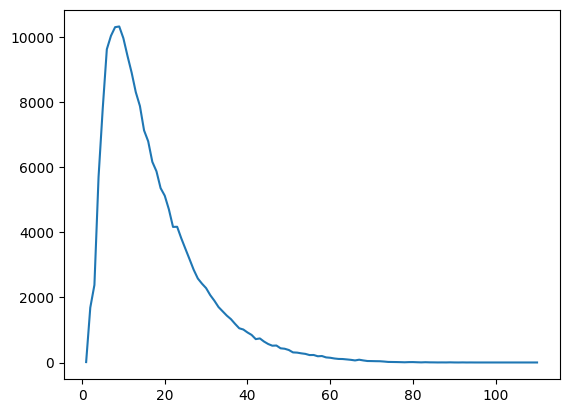

In [15]:
lens = train_dataset.cnt_src.keys()
freq = train_dataset.cnt_src.values()
z = list(zip(lens, freq))

z.sort()
lens = [t[0] for t in z]
freq = [t[1] for t in z]
plt.plot(lens, freq)

In [16]:
from lstm3 import LSTM_3

config['src_vocab_size'] = len(vocab_src)
config['trg_vocab_size'] = len(vocab_trg)
model = LSTM_3(config=config).to(device)

In [ ]:
src_filename = filenames['train_src']
trg_filename = filenames['train_trg']
def filter_data(src_filename, trg_filename):
    with open(src_filename, 'r', encoding='utf-8') as f_src, \
        open(trg_filename, 'r', encoding='utf-8') as f_trg:
        lines_src = f_src.readlines()
        lines_trg = f_trg.readlines()
        with open(src_filename, 'w', encoding='utf-8') as f_train_src, \
            open(trg_filename, 'w', encoding='utf-8') as f_train_trg:
            print(len(lines_src))
            for i in range(len(lines_src)):
                l1 = len(lines_src[i].split())
                l2 = len(lines_trg[i].split())
                # if l1 > 3 * l2 or 3 * l1 < l2:
                #     f_src.write(lines_src[i])
                #     f_trg.write(lines_trg[i])
                tokens_src = vocab_src.encode_line(lines_src[i])
                tokens_trg = vocab_trg.encode_line(lines_trg[i])
                unk_src = tokens_src.count(unk_idx)
                unk_trg = tokens_trg.count(unk_idx)
                if unk_src * 5 >= l2 or unk_trg * 5 >= l2 or l1 > 3 * l2 or 3 * l1 < l2:
                    pass
                    # print(vocab_src.decode(tokens, ignore=set()))
                else:
                    f_train_src.write(lines_src[i])
                    f_train_trg.write(lines_trg[i])

194353
